# Emotion Recognition CNN

## 1. Setup

### 1.1 Import Data from Drive

#### 1.1.1 Mount drive

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### 1.1.2 List the contents of current working directory

In [2]:
!ls

drive  sample_data


#### 1.1.3 Copy the data zip file from Drive to current working directory

In [0]:
# !cp drive/'My Drive'/radhakrishna.tar.gz /content
!cp drive/'My Drive'/krishna.tar.gz /content

#### 1.1.4 Unzip the data zip file

In [0]:
# !tar -xvzf radhakrishna.tar.gz
!tar -xvzf krishna.tar.gz

#### 1.1.5 List all the files in Aligned directory

In [5]:
!cd Aligned/ && ls

Negative  Neutral  Positive


### 1.2 Import required libraries

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import style
 
# Matplotlib configuration
%matplotlib inline  
style.use('fivethirtyeight')

# Keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Activation, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU
from keras.utils.data_utils import get_file

# Tensorflow
import tensorflow as tf

# Image manipulation libraries
import cv2                  
from PIL import Image

# Other libraries
import random
from tqdm import tqdm
import os
import itertools

# Set seed for random number generators
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


## 2. Data Preprocessing

In [0]:
# data
X = []
# labels
X_labels = []

# size of the image - 64x64
IMG_SIZE = 64

# assign variables for paths of each class
POSITIVE_DIR = 'Aligned/Positive/'
NEUTRAL_DIR = 'Aligned/Neutral/'
NEGATIVE_DIR = 'Aligned/Negative/'

### 2.1 Function to generate training data from given images and labels

In [0]:
def generate_data_from_images(emotion_type, directory):
  # tqdm used for progress bar
  # for each image in the specified directory
  for image in tqdm(os.listdir(directory)):
    filename = os.fsdecode(image)
    if filename.endswith(".jpg"): 
      # read the colored image
      image = cv2.imread(os.path.join(directory, image))
      # resize image to 64x64
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      
      # append the image as a numpy array to X
      X.append(np.array(image))
      # append the label to Z
      X_labels.append(emotion_type)

### 2.2 Generate data for "Positive" images

In [9]:
generate_data_from_images('Positive', POSITIVE_DIR)

100%|██████████| 16801/16801 [00:03<00:00, 4502.07it/s]


### 2.3 Generate data for "Neutral" images

In [10]:
generate_data_from_images('Neutral', NEUTRAL_DIR)

100%|██████████| 9265/9265 [00:02<00:00, 4490.90it/s]


### 2.4 Generate data for "Negative" images

In [11]:
generate_data_from_images('Negative', NEGATIVE_DIR)

100%|██████████| 8467/8467 [00:01<00:00, 4319.71it/s]


### 2.5 Check the size of the dataset

In [12]:
len(X), len(X_labels)

(34530, 34530)

### 2.6 Visualize some images from the dataset

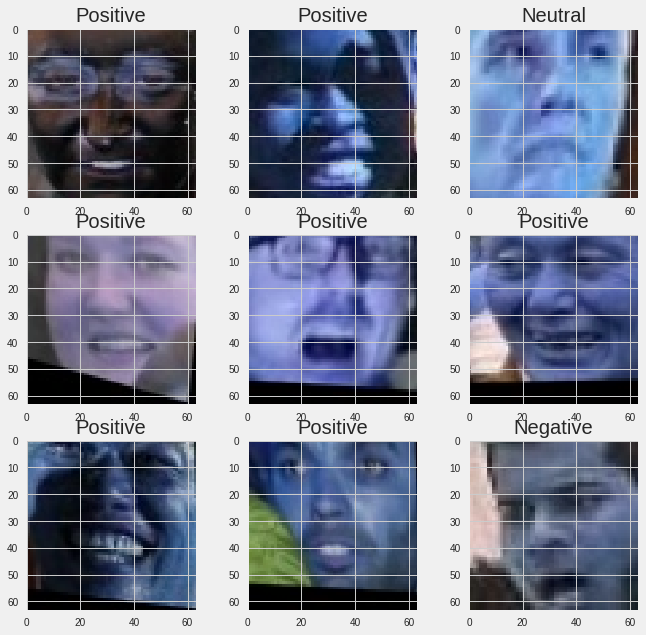

In [13]:
cols = 3
rows = 3
fig, axis = plt.subplots(rows, cols)
fig.set_size_inches(10, 10)
for i in range(rows):
  for j in range(cols):
    image_index = random.randint(0, len(X))
    axis[i, j].imshow(X[image_index])
    axis[i, j].set_title(X_labels[image_index])

### 2.7 Label Encoding and One-Hot Encoding the labels (Convert categorical text data into model-understandable numerical data)
Basically, we want to convert the 3 label classes "positive", "neutral" and "negative" into corresponding numerical classes - 2, 1 and 0.

In [14]:
# initialize the label encoder class
labelencoder = LabelEncoder()

# Convert the 3 classes "positive", "neutral" and "negative" into corresponding 
# numerical classes - 2, 1 and 0.
Y = labelencoder.fit_transform(X_labels)
# Check the classes applied by the Label Encoder
labelencoder_classes = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(labelencoder_classes)
# Apply one-hot encoding to convert the label encoded categorical data
# into multiple columns where each numerical class is replaced by 0 or 1
Y = to_categorical(Y,3)

# Convert X into a numpy array
X = np.array(X)
# Normalize all the pixel values for each image by diving by 255
X = X/255

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


### 2.8 Split the data into training set and validation set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 3. Modelling

### 3.1 Building the CNN Model

#### 3.1.1 Model 1

In [0]:
model = Sequential()

# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 5x5 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = relu
# (iv) input_shape = 64x64x3 because our input images are 64x64 and rgb
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
# Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

# fully connected layer
model.add(Dense(512))

# Relu activation layer
model.add(Activation('relu'))

# Fully connected layer with softmax activation
model.add(Dense(3, activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

#### 3.1.2 Model 2

In [0]:
# Adapted from https://github.com/a514514772/Real-Time-Facial-Expression-Recognition-with-DeepLearning

model = Sequential()

# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D((1,1), input_shape=(64,64,3)))
# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 3x3 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = relu
model.add(Conv2D(32, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
# max pooling layer
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())

# fully connected layer with ReLu activation
model.add(Dense(1024, activation='relu'))
# dropout
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# fully connected layer with softmax activation
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.1.3 Model 3

In [0]:
model = Sequential()

# Block 1

# Convolution layer
# (i) filters = 64 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 5x5 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) border_mode = valid. This gives an output that is smaller than the 
# input because the convolution is only computed where the input and the filter 
# fully overlap.
# (iv) input_shape = 64x64x3 because our input images are 64x64 and rgb
model.add(Conv2D(64, 5, 5, border_mode='valid', input_shape=(64, 64, 3)))
# Parametric Rectified Linear Unit activation layer
model.add(PReLU(init='zero', weights=None))
# Zero-padding layer to add 2 pixels of padding to the height and width of the
# image
model.add(ZeroPadding2D(padding=(2, 2), dim_ordering='tf'))
# Max pooling layer
model.add(MaxPooling2D(pool_size=(5, 5),strides=(2, 2)))
# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 2
model.add(Conv2D(64, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf')) 

# Block 3
model.add(Conv2D(64, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 4
model.add(Conv2D(128, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))

# Block 5
model.add(Conv2D(128, 3, 3))
model.add(PReLU(init='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
# Average pooling
model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))

# Block 6
model.add(Flatten())

# Block 7
# fully connected layer
model.add(Dense(2048))
model.add(PReLU(init='zero', weights=None))
# dropout
model.add(Dropout(0.2))

# Block 8
model.add(Dense(1024))
model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

# Block 8
model.add(Dense(512))
model.add(PReLU(init='zero', weights=None))
model.add(Dropout(0.2))

# Block 9
model.add(Dense(3))

# Block 10
# softmax activation function
model.add(Activation('softmax'))

# optimizer = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)

# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

# after optimization
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.1.4 Model 4

In [0]:
model = Sequential()

model.add(ZeroPadding2D((1,1), input_shape=(64, 64, 3)))

# Convolution layer
# (i) filters = 32 (the number of output filters i.e. number of feature maps 
# in the convolution)
# (ii) kernel_size = 3x3 (the height and width of the 2D convolution kernel 
# (also known as a feature detector))
# (iii) activation = ReLu
model.add(Conv2D(32, 3, 3, activation='relu'))
# Zero-padding layer to add 1 pixel of padding to the height and width of the
# image
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
# max pooling layer
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))


model.add(Flatten())

# fully connected layer with ReLu activation
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# fully connected layer with softmax activation
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### 3.1.5 Model 5

In [0]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (11,11),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3, activation = "softmax"))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

#### 3.1.6 Model 6 (Transfer learning with VGGFace)

In [16]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-bfpbjoqu
  Stored in directory: /tmp/pip-ephem-wheel-cache-yf26kr4b/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [19]:
from keras.engine import Model
from keras_vggface.vggface import VGGFace

# initialize the VGGFace model
# exclude the top layer and set input shape to the shape of our images
vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
# get the output of the last layer
last_layer = vgg_model.get_layer('pool5').output
# flatten the last layer
x = Flatten(name='flatten')(last_layer)
# add a fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc6')(x)
# add another fully connected layer with ReLu activation
x = Dense(512, activation='relu', name='fc7')(x)
# add a final fully connected layer with 3 neurons corresponding to our 3 classes and 
# a softmax activation since this is a multiclass classification problem
out = Dense(3, activation='softmax', name='fc8')(x)
# set the input and output for the model
model = Model(vgg_model.input, out)

# compile the model
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
58916864/58909280 [==============================] - 1s 0us/step


#### 3.1.7 Model 7 (Transfer learning with VGG-16)

In [0]:
# set the paths for the weights file of VGG16
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# define the model
def VGG16():

    img_input = Input(shape=(64, 64, 3))
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = GlobalAveragePooling2D()(x)

    top = Dense(256, activation='relu', name='fc')(x)
    top = Dropout(0.5)(top)
    out = Dense(3, activation='softmax', name='predictions')(top)

    model = Model(img_input, out, name='vgg16')

    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            WEIGHTS_PATH_NO_TOP,
                            cache_subdir='models')
    model.load_weights(weights_path, by_name=True)
    
    return model


lr = 0.0001

optimizer = Adagrad(lr, decay=1e-4)
model = VGG16()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### 3.2 Set Model Training Parameters

In [0]:
batch_size=128
# batch_size = 64
# epochs=10

### 3.3 Data Augmentation

In [0]:
# define the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zoom_range = 0.1, 
        vertical_flip=False)

# fit on our training set
datagen.fit(X_train)

### 3.4 Model Summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 128)       0         
__________

### 3.5 Estimate class weights since our dataset is unbalanced

In [0]:
# get the position of the largest value for each label in y_train
# eg - argmax([0., 0., 1.]) = 2
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)

### 3.6  Fit the model on the Training set and making predictions on the Validation set

In [0]:
callbacks = []
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks.append(earlystop)

# history = model.fit(X_train,y_train, nb_epoch=400, \
#             batch_size=batch_size, \
#             validation_split=0.2, \
#             shuffle=True, verbose=1, \
#             callbacks=callbacks, class_weight=class_weights)

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 400, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=callbacks, class_weight=class_weights)

Epoch 1/400
215/215 [==============================] - 79s 368ms/step - loss: 0.8287 - acc: 0.6047 - val_loss: 0.7799 - val_acc: 0.6397
Epoch 2/400
215/215 [==============================] - 75s 348ms/step - loss: 0.7535 - acc: 0.6566 - val_loss: 0.7560 - val_acc: 0.6499
Epoch 3/400
215/215 [==============================] - 72s 335ms/step - loss: 0.6965 - acc: 0.6864 - val_loss: 0.7463 - val_acc: 0.6613
Epoch 4/400
215/215 [==============================] - 72s 335ms/step - loss: 0.6209 - acc: 0.7248 - val_loss: 0.7749 - val_acc: 0.6565
Epoch 5/400
215/215 [==============================] - 72s 335ms/step - loss: 0.5102 - acc: 0.7825 - val_loss: 0.8740 - val_acc: 0.6493
Epoch 6/400
215/215 [==============================] - 72s 334ms/step - loss: 0.3787 - acc: 0.8463 - val_loss: 0.9422 - val_acc: 0.6410
Epoch 7/400
215/215 [==============================] - 72s 334ms/step - loss: 0.2725 - acc: 0.8944 - val_loss: 1.1820 - val_acc: 0.6402
Epoch 8/400
215/215 [===========================

### 3.7 Save the Model and weights

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("vggface_adam.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vggface_adam.h5")
print("Saved model to disk")

Saved model to disk


## 4. Evaluate Model Performance

### 4.1 Loss vs Epochs Graph

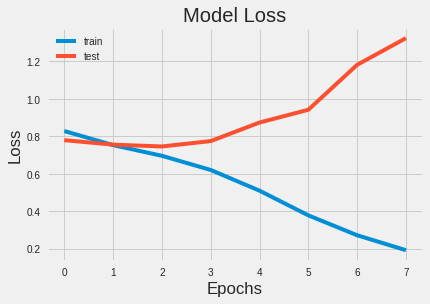

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### 4.2 Accuracy vs Epochs Graph

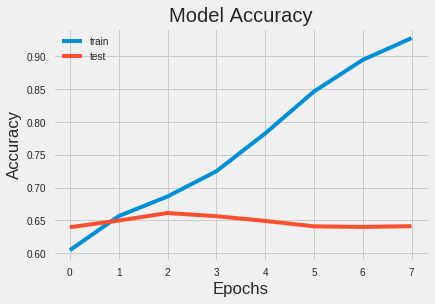

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### 4.3 Confusion Matrix

#### 4.3.1 Get the predictions on the validation set

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

#### 4.3.2 Function to plot the confusion matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### 4.3.3 Plot the Confusion Matrix

Confusion matrix, without normalization
[[ 863  484  326]
 [ 521  989  348]
 [ 327  471 2577]]


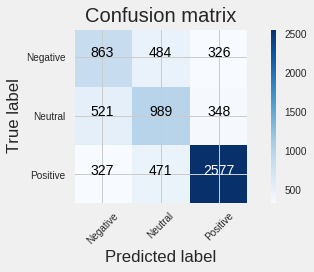

In [0]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure()
plot_confusion_matrix(cm, classes=labelencoder.classes_)
plt.show()

### 4.4 Calculate the Accuracy on the Validation Set

In [0]:
accuracy_score(y_true, y_pred_classes)

0.6413263828554879

---